# Model flow on comp_data_household 


## Import packages and data

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from earthquake_damage.ml_logic.preprocessor import cus_imputation, preprocess_features, preprocess_targets
from earthquake_damage.data.main import train_test_val

## Imputation and preprocess the data 

In [7]:
cus_imputation(filename = 'comp_data_household')


Imputation...

✅  There are 26 vaules missing in the dataset.

✅ df_imputed, with shape (747137, 44)
✅ df_imputed saved to /Users/caobai/code/chantalwuer/earthquake_damage/processed_data/df_imputed.csv


In [8]:
preprocess_features()
preprocess_targets()


✅ X_processed, with shape (747137, 79)
✅ X_processed saved to /Users/caobai/code/chantalwuer/earthquake_damage/processed_data/X_processed.csv

Preprocess target...

✅ y processed, with shape (747137,)
✅ y_processed saved to /Users/caobai/code/chantalwuer/earthquake_damage/processed_data/y_processed.csv


In [11]:
X = pd.read_csv('/Users/caobai/code/chantalwuer/earthquake_damage/processed_data/X_processed.csv')
y = pd.read_csv('/Users/caobai/code/chantalwuer/earthquake_damage/processed_data/y_processed.csv')


In [7]:
X.shape, y.shape

((747137, 79), (747137, 1))

## Check data statistics

In [21]:
X.isna().sum().sum()

0

In [22]:
X.duplicated().sum()

0

In [25]:
y.value_counts()

damage_grade
4               276274
3               181467
2               132168
1                83609
0                73619
dtype: int64

In [32]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val()

In [13]:
# y_train = y_train['damage_grade']
# y_val = y_val['damage_grade']
# y_test = y_test['damage_grade']

KeyError: 'damage_grade'

## PCA on dimensionality reduction 
### The accuracy & f1_micro score is better without PCA 

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)


In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)


KNeighborsClassifier()

In [30]:
X_val_pca = pca.transform(X_val)
y_val_pred_pca = knn.predict(X_val_pca)


In [31]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_val, y_val_pred_pca)

0.3802300040908671

In [32]:
knn.fit(X_train, y_train)
y_val_pred = knn.predict(X_val)

In [33]:
balanced_accuracy_score(y_val, y_val_pred)

0.4038442715541331

In [34]:
from sklearn.metrics import f1_score

print('f1-micro with pca',f1_score(y_test, y_val_pred_pca, average='micro'))
print('f1-micro without pca',f1_score(y_test, y_val_pred, average='micro'))


f1-micro with pca 0.25027884109180787
f1-micro without pca 0.2532412488511747


In [14]:
from sklearn.metrics import f1_score
f1_score(y_val, y_val_pred, average='micro')

0.5820506643110172

### Use model.feature_importances_ to select features is better than selectpercentile method

In [123]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_jobs=-1)

xgb_model.fit(X_train, y_train)

y_val_pred = xgb_model.predict(X_val)


In [243]:
len(X_train.columns)

79

In [128]:
pd.set_option('display.max_rows', None)
a = pd.DataFrame(xgb_model.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)
model_feature = a.head(76).index
model_feature 

Index(['pipeline-1__has_superstructure_mud_mortar_stone',
       'pipeline-1__district_id',
       'pipeline-2__foundation_type_Mud mortar-Stone/Brick',
       'pipeline-2__ground_floor_type_RC',
       'pipeline-1__has_superstructure_stone_flag',
       'pipeline-2__roof_type_RCC/RB/RBC', 'pipeline-1__vdcmun_id',
       'pipeline-2__other_floor_type_TImber/Bamboo-Mud', 'pipeline-1__ward_id',
       'pipeline-1__has_superstructure_cement_mortar_brick',
       'pipeline-1__has_superstructure_adobe_mud',
       'pipeline-2__foundation_type_RC', 'pipeline-1__household_id',
       'pipeline-1__has_superstructure_mud_mortar_brick',
       'pipeline-1__has_superstructure_rc_engineered',
       'pipeline-2__other_floor_type_Not applicable',
       'pipeline-2__foundation_type_Bamboo/Timber',
       'pipeline-2__ground_floor_type_Timber',
       'pipeline-1__has_superstructure_timber',
       'pipeline-2__roof_type_Bamboo/Timber-Light roof',
       'pipeline-1__has_secondary_use', 'pipeline-2_

In [129]:
xgb_model.fit(X_train[model_feature], y_train)

y_val_pred_model_feature = xgb_model.predict(X_val[model_feature])

f1_score(y_val, y_val_pred_model_feature, average='micro')

0.5820238955662036

### Use SelectPrecentile to select top 8 features from the dataset

# GridSearch best parameter for XGBoostclassifier

In [135]:
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.filterwarnings('ignore')


In [136]:
grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.3, 0.5,1],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [137]:
model = XGBClassifier(n_jobs=-1, n_estimators=100, random_state=42)
search = GridSearchCV(model, grid, scoring="f1_micro", n_jobs=-1, cv=3, verbose=1)


In [138]:
search.fit(X_train[model_feature], y_train) 

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'gamma': [0, 0.25, 1],
                         'learning_rate': [0.1, 0.3, 0.5, 1],
                         'max_depth': [3, 4, 5, 7], 'reg_lambda': [0, 1, 10],
                         'subsample': [0.8]},
             scoring='f1_micro', verbose=1)

In [140]:
search.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 1,
 'max_depth': 7,
 'reg_lambda': 10,
 'subsample': 0.8}

In [141]:
search.best_score_

0.5925735434158835

In [142]:
search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [212]:
best_model = XGBClassifier(n_jobs=-1, n_estimators=100, random_state=42, colsample_bytree=0.5,
    gamma=0, learning_rate=1, max_depth=7, reg_lambda=10, subsample=0.8)
best_model.fit(X_train[model_feature], y_train)  

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [234]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

y_val_best = best_model.predict(X_val[model_feature])
print(f1_score(y_val, y_val_best, average='micro'))
print(precision_score(y_val, y_val_best, average='weighted'))
print(accuracy_score(y_val, y_val_best, normalize=True))
print(recall_score(y_val, y_val_best, average=None))

0.5976300737925065
0.5874487552383415
0.5976300737925065
[0.7249047  0.36618925 0.42143074 0.50285631 0.77921109]


In [218]:
probability = pd.DataFrame(best_model.predict_proba(X_test[model_feature].iloc[0:1, :]))
probability.columns = ['damage_grade_1', 'damage_grade_2', 'damage_grade_3','damage_grade_4', 'damage_grade_5']
probability.index = ['probability']
probability

,damage_grade_1,damage_grade_2,damage_grade_3,damage_grade_4,damage_grade_5
probability,0.004169,0.033499,0.155093,0.178457,0.628782


In [240]:
model_feature

Index(['pipeline-1__has_superstructure_mud_mortar_stone',
       'pipeline-1__district_id',
       'pipeline-2__foundation_type_Mud mortar-Stone/Brick',
       'pipeline-2__ground_floor_type_RC',
       'pipeline-1__has_superstructure_stone_flag',
       'pipeline-2__roof_type_RCC/RB/RBC', 'pipeline-1__vdcmun_id',
       'pipeline-2__other_floor_type_TImber/Bamboo-Mud', 'pipeline-1__ward_id',
       'pipeline-1__has_superstructure_cement_mortar_brick',
       'pipeline-1__has_superstructure_adobe_mud',
       'pipeline-2__foundation_type_RC', 'pipeline-1__household_id',
       'pipeline-1__has_superstructure_mud_mortar_brick',
       'pipeline-1__has_superstructure_rc_engineered',
       'pipeline-2__other_floor_type_Not applicable',
       'pipeline-2__foundation_type_Bamboo/Timber',
       'pipeline-2__ground_floor_type_Timber',
       'pipeline-1__has_superstructure_timber',
       'pipeline-2__roof_type_Bamboo/Timber-Light roof',
       'pipeline-1__has_secondary_use', 'pipeline-2_

In [237]:
pd.DataFrame(best_model.feature_importances_, index=X_train[model_feature].columns).sort_values(by=0, ascending=False)


,0
pipeline-2__foundation_type_Mud mortar-Stone/Brick,0.135556
pipeline-1__district_id,0.128339
pipeline-1__has_superstructure_mud_mortar_stone,0.122987
pipeline-1__has_superstructure_cement_mortar_brick,0.045949
pipeline-1__has_superstructure_stone_flag,0.044791
pipeline-1__ward_id,0.032343
pipeline-1__vdcmun_id,0.031924
pipeline-2__ground_floor_type_RC,0.028327
pipeline-2__other_floor_type_TImber/Bamboo-Mud,0.028218
pipeline-2__ground_floor_type_Mud,0.025543


# Save the fitted best model into a pickle

In [15]:
from xgboost import XGBClassifier
fit_model = XGBClassifier(n_jobs=-1, n_estimators=100, random_state=42, colsample_bytree=0.5,
    gamma=0, learning_rate=1, max_depth=7, reg_lambda=10, subsample=0.8)

In [245]:
# from imblearn.over_sampling import SMOTE 
# smote = SMOTE(random_state=42)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [22]:
X_train.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78']
fit_model.fit(X_train, y_train)  

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [24]:
# save the best fitted model 
import pickle 
pickle.dump(fit_model, open('fit_best_model.pkl', 'wb'))

In [20]:
len(X_train.columns)

79

In [25]:
from earthquake_damage.data.model_input import get_model_input
a = get_model_input(district_id=12, municipality_id=1201, ward=5, age=5, floors=2, superstructure=5,
                    foundation = 'Mud mortar-Stone/Brick',
                    floor = 'Mud', roof = 'Bamboo/Timber-Light roof')

/Users/caobai/code/chantalwuer/earthquake_damage/earthquake_damage/data/model_input.py:100: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  smaller_df_wards = smaller_df_wards[age_mask]


In [26]:
a

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,-1.5,-1.498759,-1.498859,0.0,-0.611111,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
pickled_model = pickle.load(open('fit_best_model.pkl', 'rb'))

In [29]:
pickled_model.predict_proba(a)

array([[0.83988386, 0.07397857, 0.03249903, 0.03667301, 0.01696552]],
      dtype=float32)

In [64]:
pd.set_option('display.max_rows', None) 
b = pd.DataFrame(pickled_model.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False).iloc[0:15, :]
b

,0
pipeline-1__has_superstructure_mud_mortar_stone,0.221928
pipeline-2__other_floor_type_RCC/RB/RBC,0.105308
pipeline-1__vdcmun_id,0.097054
pipeline-2__other_floor_type_TImber/Bamboo-Mud,0.030128
pipeline-2__foundation_type_RC,0.028723
pipeline-1__ward_id,0.027193
pipeline-2__ground_floor_type_RC,0.025272
pipeline-2__foundation_type_Mud mortar-Stone/Brick,0.022762
pipeline-1__household_id,0.022279
pipeline-1__has_superstructure_cement_mortar_brick,0.019976


Text(0.5, 1.0, 'Distribution of Building Superstructure Composition')

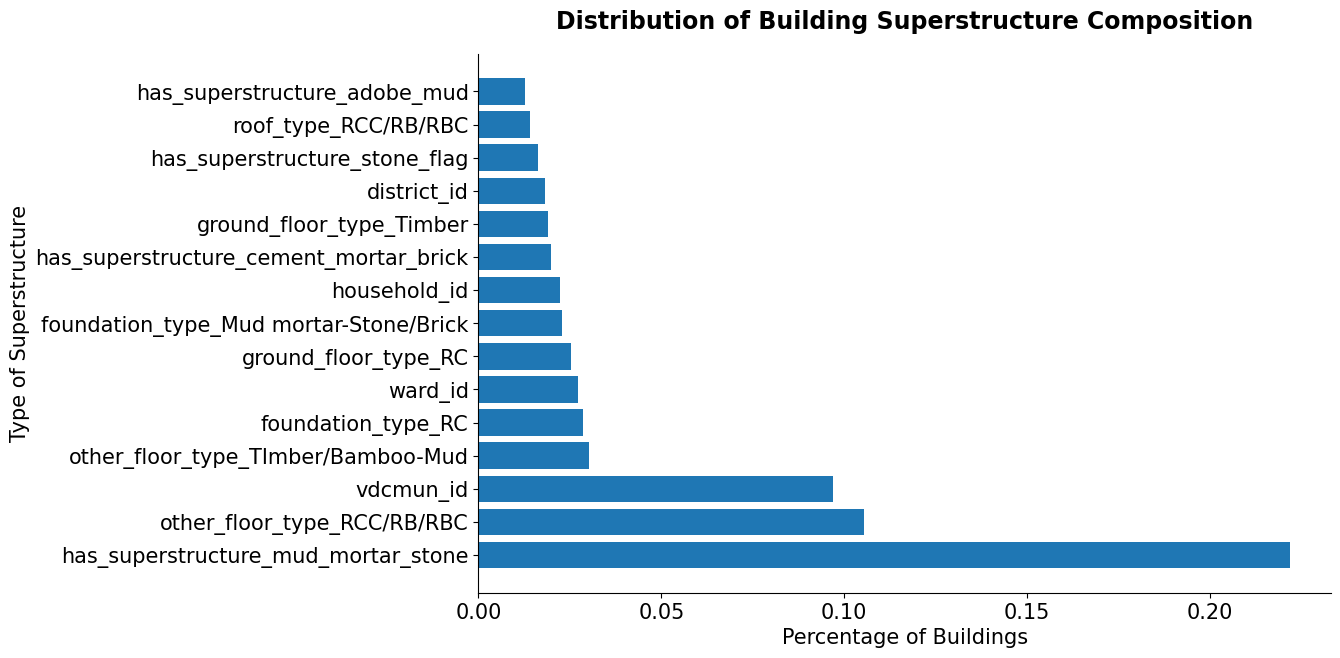

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
y = [0.22192805, 0.10530818, 0.09705386,0.03012835,0.02872306, 0.02719299,0.0252717,0.02276159,0.02227921,0.01997644,0.01902411,0.01820221,0.01623734,0.01408556,0.01267308] 
x = [item[12:] for item in b.index.tolist()]
fig, ax = plt.subplots(figsize=(11,7))
ax.barh(x, y)
ax.grid(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.tick_params(axis='both', labelsize=15);
ax.set_xlabel('Percentage of Buildings', size = 15)
ax.set_ylabel("Type of Superstructure", size = 15)

ax.set_title('Distribution of Building Superstructure Composition', weight="bold", size = 17, pad =18) 